In [19]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#공용함수

In [ ]:
# 수정금지: 타임스탬프용 함수
from datetime import datetime
def printt(*args,**kwargs):
  now = datetime.now()
  now_str = "{:02}:{:02}:{:02}".format(now.hour,now.minute,now.second)
  print(now_str, *args,**kwargs)
  return int(now.hour)*60*60+int(now.minute)*60+int(now.second)

#연관 패키지 설치 (다른작업 금지)

In [20]:
#TODO: 해당 블럭에 패키지 설치하세요.
!pip install attrdict
!pip install transformers
!pip install seqeval
!pip install fastprogress

# 파일로딩 (다른작업 금지)

In [ ]:
#TODO: 해당 블럭에 필요 파일 로딩 코드 넣으시오.


# 모델 학습

In [ ]:
# 수정금지: 타임스탬프
_model_build_start_time = printt("Model building: Start")
_model_build_start_time

08:34:48 Model building: Start


30888

In [ ]:
#TODO: 블럭에 모델 학습 - 빌딩 코드를 넣으세요. (시간측정 구간)





In [21]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


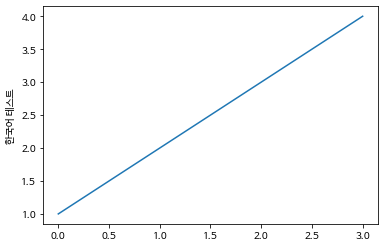

In [22]:
# 실행 전 런타임 다시시작
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
plt.plot([1, 2, 3, 4])
plt.ylabel('한국어 테스트')
plt.show()

In [23]:
# task = 'classification'
task = 'sentiment'
train_file = 'train_cls.txt'
test_file = 'evaluation_cls.txt'
full_text = 'full_text.txt'


# train_file = train_s_cls.txt
# test_file = test_s_cls.txt

In [24]:
# initialize logging
import logging

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [25]:
# make Input Example
class InputExample(object):
    """
    A single training/test example for simple sequence classification.
    """

    def __init__(self, guid, text_a, text_b, label):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"
        
# make Input Feature
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

# make processor
class Processor(object):

    def __init__(self, args):
        self.args = args

    def get_labels(self):
        if self.args.task == 'classification':
        # return ['None', '상담원', '상담시스템', '고객서비스', '혜택', '할부금융상품', '커뮤니티서비스',
        #         '카드이용/결제', '카드상품', '청구입금', '심사/한도', '생활편의서비스', '상담/채널', '리스렌탈상품',
        #         '라이프서비스', '금융상품', '고객정보관리', '가맹점매출/승인', '가맹점대금', '가맹점계약', '삼성카드', '기타']
          return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                  '13', '14', '15', '16']
        else:
          return ['0', '1']

    def _read_file(cls, input_file):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            lines = []
            for line in f:
                lines.append(line.strip())
            return lines

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines[0:]):
            line = line.split("\t")
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            if i % 10000 == 0:
                logger.info(line)
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, test
        """
        file_to_read = None
        if mode == "train":
            file_to_read = self.args.train_file
        elif mode == "test":
            file_to_read = self.args.test_file

        logger.info("LOOKING AT {}".format(os.path.join(self.args.data_dir, file_to_read)))
        return self._create_examples(
            self._read_file(os.path.join(self.args.data_dir, file_to_read)), mode
        )

In [26]:
# set config args for classification
from transformers import (
    ElectraConfig,
    ElectraTokenizer,
    ElectraForSequenceClassification,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMRobertaConfig
)
from attrdict import AttrDict
args = AttrDict(
    {
                 'data_dir': 'data/{}'.format(task),
                 'train_file': train_file,
                 'test_file': test_file,
                 'task': task,
                 'config': ElectraConfig,
                 'tokenizer': ElectraTokenizer,
                 'model': ElectraForSequenceClassification,
                #  'config': XLMRobertaConfig,
                #  'tokenizer': XLMRobertaTokenizer,
                #  'model': XLMRobertaForSequenceClassification,
                 'evaluate_test_during_training': True, 
                 'eval_all_checkpoints': True, 
                 'save_optimizer': False, 
                 'do_lower_case': False, 
                 'do_train': True, 
                 'do_eval': True, 
                 'max_seq_len': 128, 
                 'num_train_epochs': 20, 
                 'weight_decay': 0.0, 
                 'gradient_accumulation_steps': 1, 
                 'adam_epsilon': 1e-08, 
                 'warmup_proportion': 0, 
                 'max_steps': -1, 
                 'max_grad_norm': 1.0, 
                 'no_cuda': False, 
                 'model_type': 'koelectra-base-v3', 
                 'model_name_or_path': 'monologg/koelectra-base-v3-discriminator', 
                 'output_dir': '{}_checkpoints'.format(task), 
                 'seed': 42, 
                 'train_batch_size': 32, 
                 'eval_batch_size': 128, 
                 'logging_steps': 250, 
                 'save_steps': 250, 
                 'learning_rate': 5e-06
     }
)
if task == 'sentiment':
  args.logging_steps, args.save_steps = 63, 63
  args.max_seq_len = 64
  args.train_batch_size = 128

In [27]:
import torch

# set seed
torch.cuda.manual_seed_all(args.seed)

processor = Processor(args)
labels = processor.get_labels()


config = args.config.from_pretrained(
            args.model_name_or_path,
            num_labels=len(labels)
            # id2label={str(i): label for i, label in enumerate(labels)},
            # label2id={label: i for i, label in enumerate(labels)},
        )
tokenizer = args.tokenizer.from_pretrained(
    args.model_name_or_path,
    do_lower_case=args.do_lower_case
)
model = args.model.from_pretrained(
    args.model_name_or_path,
    config=config
)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [28]:
%cd /content/drive/MyDrive/Colab Notebooks
import os
from torch.utils.data import TensorDataset
logger = logging.getLogger(__name__)
print(__name__)
def load_and_cache_examples(args, tokenizer, mode):
    processor = Processor(args)
    output_mode = args.task
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}_{}".format(
            str(args.task), list(filter(None, args.model_name_or_path.split("/"))).pop(), str(args.max_seq_len), mode
        ),
    )
    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "test":
            examples = processor.get_examples("test")
        else:
            raise ValueError("For mode, choose between train and test")
        features = seq_cls_convert_examples_to_features(
            args, examples, tokenizer, max_length=args.max_seq_len
        )
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)



    if output_mode == "classification" or 'sentiment':
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)


    # if output_mode == "classification":
    #     all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    # elif output_mode == "regression":
    #     all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset
def seq_cls_convert_examples_to_features(args, examples, tokenizer, max_length):
    processor = Processor(args)
    label_list = processor.get_labels()
    output_mode = args.task
    logger.info("Using label list {}".format(label_list))
    logger.info("Using output mode {}".format(output_mode))

    # labels = [label_from_example(example) for example in examples]
    labels = [int(example.label) for example in examples]

    batch_encoding = tokenizer.batch_encode_plus(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        add_special_tokens=True,
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}
        if "token_type_ids" not in inputs:
            inputs["token_type_ids"] = [0] * len(inputs["input_ids"])  # For xlm-roberta

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        logger.info("*** Example ***")
        logger.info("guid: {}".format(example.guid))
        logger.info("input_ids: {}".format(" ".join([str(x) for x in features[i].input_ids])))
        logger.info("attention_mask: {}".format(" ".join([str(x) for x in features[i].attention_mask])))
        logger.info("token_type_ids: {}".format(" ".join([str(x) for x in features[i].token_type_ids])))
        logger.info("label: {}".format(features[i].label))

    return features



/content/drive/MyDrive/Colab Notebooks
__main__


In [29]:
import argparse
import json
import logging
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm


def train(args,
          model,
          train_dataset,
          test_dataset=None):
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    full_text = pd.read_csv(os.path.join(args.data_dir, 'full_text.txt'), sep='\t')
    # full_text = pd.read_csv('train_n_full.txt', sep='\t')
    print(full_text)
    if args.max_steps > 0:
        t_total = args.max_steps
        print()
        print(t_total, len(train_dataloader), args.gradient_accumulation_steps)
        print()
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
        print('max steps: ' + str(t_total), 'length of train data: ' + str(len(train_dataloader)),
              args.gradient_accumulation_steps)
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args.warmup_proportion),
                                                num_training_steps=t_total)

    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
            os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Total train batch size = %d", args.train_batch_size)
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)
    logger.info("  Logging steps = %d", args.logging_steps)
    logger.info("  Save steps = %d", args.save_steps)

    global_step = 0
    tr_loss = 0.0

    model.zero_grad()
    mb = master_bar(range(int(args.num_train_epochs)))
    for epoch in tqdm(mb):
        epoch_iterator = progress_bar(train_dataloader, parent=mb)

        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3]
            }

            if args.model_type not in ["distilkobert", "xlm-roberta"]:
                inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()
            tr_loss += loss.item()


            if (step + 1) % args.gradient_accumulation_steps == 0 or (
                    len(train_dataloader) <= args.gradient_accumulation_steps
                    and (step + 1) == len(train_dataloader)
            ):
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step += 1


                print("loss: " + str(tr_loss / global_step))


                if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    if args.evaluate_test_during_training:
                        evaluate(args, model, full_text, test_dataset, "test", global_step)

                if args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )
                    model_to_save.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to {}".format(output_dir))

                    if args.save_optimizer:
                        torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                        torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                        logger.info("Saving optimizer and scheduler states to {}".format(output_dir))
            if args.max_steps > 0 and global_step > args.max_steps:
                break

        mb.write("Epoch {} done".format(epoch + 1))

        if args.max_steps > 0 and global_step > args.max_steps:
            break

    return global_step, tr_loss / global_step, full_text

In [30]:
def evaluate(args, model, full_text, eval_dataset, mode, global_step=None):
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # Eval!
    if global_step != None:
        logger.info("***** Running evaluation on {} dataset ({} step) *****".format(mode, global_step))
    else:
        logger.info("***** Running evaluation on {} dataset *****".format(mode))
    logger.info("  Num examples = {}".format(len(eval_dataset)))
    logger.info("  Eval Batch size = {}".format(args.eval_batch_size))
    eval_loss = 0.0
    # nb_eval_steps = 0
    preds = None
    out_label_ids = None
    out_input_ids = None

    for batch in progress_bar(eval_dataloader):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3]
            }

            if args.model_type not in ["distilkobert", "xlm-roberta"]:
                inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        # nb_eval_steps += 1
        if preds is None:
            out_input_ids = inputs['input_ids'].detach().cpu().numpy()
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            out_input_ids = np.append(out_input_ids, inputs['input_ids'].detach().cpu().numpy(), axis=0)
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        # 내가 수정한 부분

    tokenizer = args.tokenizer.from_pretrained(
        args.model_name_or_path,
        do_lower_case=args.do_lower_case
    )
    # label_dict = {'칭찬': 0, '중립': 0.5, '불만': 1}
    if args.task == 'classification':
      label_dict = {'중립': 0, '상담원': 1, '상담시스템': 2, '혜택': 3, '할부금융상품': 4,
                  '카드상품': 5, '청구입금': 6, '심사/한도': 7, '생활편의서비스': 8,
                  '상담/채널': 9, '리스렌탈상품': 10, '라이프서비스': 11, '금융상품': 12,
                  '고객정보관리': 13, '가맹점매출/승인': 14, '삼성카드': 15, '기타': 16}
    else:
      label_dict = {'칭찬': 0, '불만': 1}
    label_dict = dict((v, k) for k, v in label_dict.items())
    df_review = []
    # temp_review = []
    df_label = np.vectorize(label_dict.get)(out_label_ids)
    df_prediction = np.vectorize(label_dict.get(np.argmax(preds)))
    for i in range(len(out_input_ids)):
        review_list = list(out_input_ids[i])


        # temp_review.append(str(x) for x in out_input_ids[i])


        while 0 in review_list:
            review_list.remove(0)
        del review_list[0]
        del review_list[-1]
        df_review.append(tokenizer.decode(review_list))
        # print(review_list, label_dict[out_label_ids[i] - 1], label_dict[np.argmax(preds[i]) - 1])
    df_data = {'Review': df_review, 'Label': df_label, 'Prediction': df_prediction}
    df = pd.DataFrame(df_data)

    df_train_data = {'Review': full_text['Review'], 'Label': full_text['Label']}
    df_from_train = pd.DataFrame(df_train_data)
    # Dodged Bar Chart (with same X coordinates side by side)

    bar_width = 0.35
    alpha = 0.5
    label_lst = list(label_dict.values())
    index = np.arange(len(label_lst))
    count_list, cnt_pred, cnt_label = [0 for _ in range(len(label_dict))], \
                                    [0 for _ in range(len(label_dict))], [0 for _ in range(len(label_dict))]
    count_labels = df_from_train.groupby('Label', as_index=False).Review.count()
    acc_labels = df[df['Label'] == df['Prediction']].groupby('Label').Review.count()
    viable_label = list(count_labels['Label'])
    for i in range(len(viable_label)):
        count_list[viable_label[i]] = count_labels['Review'][i]
    for validation in range(len(out_label_ids)):
        if out_label_ids[validation] == np.argmax(preds, axis=1)[validation]:
            cnt_pred[out_label_ids[validation]] += 100
        cnt_label[out_label_ids[validation]] += 1
    for i in range(len(cnt_label)):
        if cnt_label[i] == 0:
            cnt_label[i] = 1
    acc_tot = np.divide(cnt_pred, cnt_label)
    acc_tot[np.isnan(acc_tot)] = 0
    # print(count_list)
    # print(acc_tot)
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.title('Bar Chart of Labels Count and Accuracy', fontsize=15)
    clrs = ['r' if (x < 15) else 'b' for x in count_list]
    p1 = plt.bar(index, count_list,
                 bar_width,
                 color=clrs,
                 alpha=alpha,
                 label='Count')
    plt.ylabel('Count of Labels', fontsize=12)
    plt.xticks([], [])
    # plt.legend((p1[0],), ('Count',), fontsize=10)
    plt.subplot(2, 1, 2)
    p2 = plt.bar(index + bar_width, acc_tot,
                 bar_width,
                 color=clrs,
                 alpha=alpha,
                 label='Accuracy')
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
    plt.ylabel('Accuracy by Labels', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.xticks(index, label_lst, fontsize=10, rotation=45)
    # plt.legend((p2[0],), ('Accuracy',), fontsize=10)
    plt.show()
        # for i in range(len(out_label_ids)):
        #     print(tokenizer.decode(out_ids[i]), out_label_ids[i], preds[i])
        # print(type(out_label_ids), type(preds))
        # print(out_label_ids, preds)
        #

    # eval_loss = eval_loss / nb_eval_steps
    # if output_modes[args.task] == "classification":
    preds_original = preds.copy()
    preds = np.argmax(preds, axis=1)
    # elif output_modes[args.task] == "regression":
    #     preds = np.squeeze(preds)
    result = compute_metrics(out_label_ids, preds)

    # 틀린 항목 정리
    check_right = out_label_ids == preds
    df = pd.DataFrame(columns=['Review', 'Label', 'Prediction', 'Softmax'])
    for check_result in range(len(check_right)):
        if not check_right[check_result]:
            review_list = list(out_input_ids[check_result])
            while 0 in review_list:
                review_list.remove(0)
            del review_list[0]
            del review_list[-1]
            df = df.append({'Review': tokenizer.decode(review_list), 
                           'Label': label_dict[out_label_ids[check_result]], 
                           'Prediction': label_dict[preds[check_result]],
                           'Softmax': preds_original[check_result]},
                           ignore_index=True
                           )
    
    print(df.head())
    df.to_csv(r'analysis_ckpt_{}_{}.csv'.format(args.task, global_step), header=None, index=None, sep='\t', mode='a')
            # print(tokenizer.decode(review_list), 'Label: ' + str(label_dict[out_label_ids[check_result]]) + ' Prediction: ' + str(
            #     label_dict[preds[check_result]]))


    # numpy_data = np.array(out_label_ids, preds)
    # df = pd.DataFrame(data=numpy_data, index=["row1", "row2"], columns=["column1", "column2"])
    print(result)
    results.update(result)
    output_dir = os.path.join(args.output_dir, mode)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_eval_file = os.path.join(output_dir,
                                    "{}-{}.txt".format(mode, global_step) if global_step else "{}.txt".format(mode))
    with open(output_eval_file, "w") as f_w:
        logger.info("***** Eval results on {} dataset *****".format(mode))
        for key in sorted(results.keys()):
            logger.info("  {} = {}".format(key, str(results[key])))
            f_w.write("  {} = {}\n".format(key, str(results[key])))

    return results

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return {"acc": (labels == preds).mean()}

In [31]:
train_dataset = load_and_cache_examples(args, tokenizer, mode="train")
test_dataset = load_and_cache_examples(args, tokenizer, mode="test")

08/11/2021 19:50:35 - INFO - __main__ -   Creating features from dataset file at data/sentiment
08/11/2021 19:50:35 - INFO - __main__ -   LOOKING AT data/sentiment/train_cls.txt
08/11/2021 19:50:35 - INFO - __main__ -   ['매우 만족합니다  감사합니다  ', '0']
08/11/2021 19:50:35 - INFO - __main__ -   Using label list ['0', '1']
08/11/2021 19:50:35 - INFO - __main__ -   Using output mode sentiment
08/11/2021 19:50:37 - INFO - __main__ -   *** Example ***
08/11/2021 19:50:37 - INFO - __main__ -   guid: train-0
08/11/2021 19:50:37 - INFO - __main__ -   input_ids: 2 6669 7538 17788 6851 17788 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/11/2021 19:50:37 - INFO - __main__ -   attention_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/11/2021 19:50:37 - INFO - __main__ -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

08/11/2021 19:50:40 - INFO - __main__ -   ***** Running training *****
08/11/2021 19:50:40 - INFO - __main__ -     Num examples = 7943
08/11/2021 19:50:40 - INFO - __main__ -     Num Epochs = 20
08/11/2021 19:50:40 - INFO - __main__ -     Total train batch size = 128
08/11/2021 19:50:40 - INFO - __main__ -     Gradient Accumulation steps = 1
08/11/2021 19:50:40 - INFO - __main__ -     Total optimization steps = 1260
08/11/2021 19:50:40 - INFO - __main__ -     Logging steps = 63
08/11/2021 19:50:40 - INFO - __main__ -     Save steps = 63


                                                 Review  Label
0                                     매우 만족합니다  감사합니다        0
1     롯데카드 상담사님은 같은 질문에도 성의 있게 답변해주시고 친절히 설명을 잘해주셔서 ...      0
2                                               수고하십니다       0
3                                       아주  최고였어요 감사합니다      0
4                                      친절하게 빠른 응대 감사드려요      0
...                                                 ...    ...
9925                                 이중 출금 안 되게 할 순 없나요      1
9926                                      좀 더 친절했으면 좋겠음      1
9927                                          상담이 불친절하다      1
9928                                     청구서 가 너무 늦지 도착      1
9929     전화연결을  하연 앱으로 넘어가는 것이 매우 불편하다 여러 번  전화를  하게 된다      1

[9930 rows x 2 columns]
max steps: 1260 length of train data: 63 1


loss: 0.6918984055519104
loss: 0.6858837008476257
loss: 0.68586798508962
loss: 0.6859230548143387
loss: 0.6851084113121033
loss: 0.6845901310443878
loss: 0.6841581378664289
loss: 0.6837301850318909
loss: 0.6828655401865641
loss: 0.6811563432216644
loss: 0.680614866993644
loss: 0.6793383359909058
loss: 0.6779740131818331
loss: 0.6763556855065482
loss: 0.675208854675293
loss: 0.6740770228207111
loss: 0.6721505838281968
loss: 0.6707414521111382
loss: 0.6689620268972296
loss: 0.6678015112876892
loss: 0.6663918268112909
loss: 0.6653238832950592
loss: 0.6634016944014508
loss: 0.6617248679200808
loss: 0.6601151299476623
loss: 0.6586761520459101
loss: 0.6568437880939908
loss: 0.6548589042254856
loss: 0.6527174074074318
loss: 0.6511004090309143
loss: 0.6491196001729658
loss: 0.6471333652734756
loss: 0.645444393157959
loss: 0.6436226052396438
loss: 0.6415411727769035
loss: 0.639280155301094
loss: 0.6376462917070131
loss: 0.6356765596490157
loss: 0.6330600059949435
loss: 0.6309093415737153
loss: 

08/11/2021 19:51:56 - INFO - __main__ -   ***** Running evaluation on test dataset (63 step) *****
08/11/2021 19:51:56 - INFO - __main__ -     Num examples = 1987
08/11/2021 19:51:56 - INFO - __main__ -     Eval Batch size = 128


loss: 0.5825208723545074


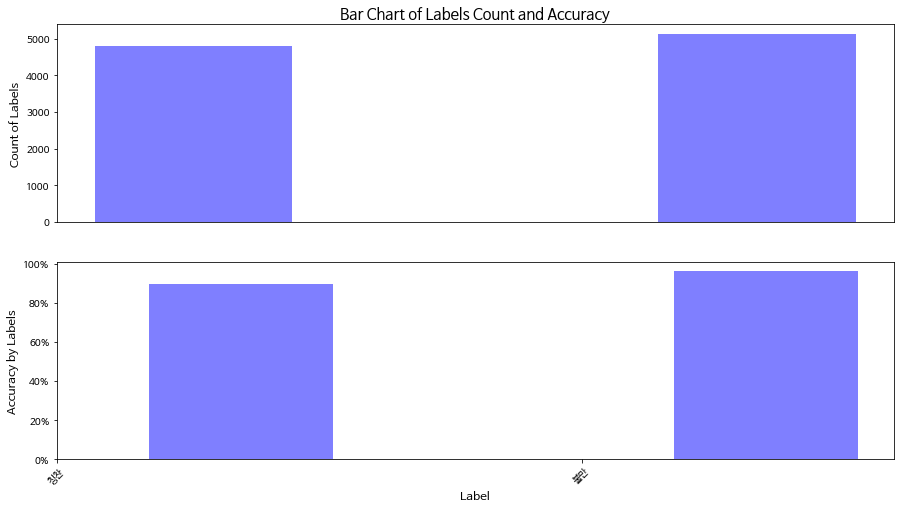

08/11/2021 19:52:06 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 19:52:06 - INFO - __main__ -     acc = 0.9315551082033215


                                       Review  ...                    Softmax
0                       상담 대기 시간이 길지 않아 좋았습니다  ...     [-0.1782206, 0.046329]
1  수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함  ...   [-0.54055625, 0.3423603]
2                                        불편하다  ...   [0.4694309, -0.31561923]
3                                      경청해주세요  ...    [0.5395025, -0.3576957]
4                                          실망  ...  [0.39695704, -0.28108317]

[5 rows x 4 columns]
{'acc': 0.9315551082033215}


08/11/2021 19:52:08 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-63


loss: 0.5805579838342965
loss: 0.5784335044714121
loss: 0.5756783693125753
loss: 0.5734128133574529
loss: 0.570810475770165
loss: 0.5679864300333936
loss: 0.565508810537202
loss: 0.5629486382847101
loss: 0.5603040150470204
loss: 0.5578378741055319
loss: 0.5554525191719467
loss: 0.553163378238678
loss: 0.5508394656996978
loss: 0.5483439878209845
loss: 0.545783166319896
loss: 0.5435521651672411
loss: 0.5410961631685496
loss: 0.5389366341225895
loss: 0.5366079814550353
loss: 0.5339892255254539
loss: 0.5313596306812196
loss: 0.528930404957603
loss: 0.526411491771077
loss: 0.5241615189903084
loss: 0.5219332914460789
loss: 0.5194856464193108
loss: 0.5172418240043852
loss: 0.5148725034771385
loss: 0.5122346803545952
loss: 0.5096919575045186
loss: 0.5073892581970134
loss: 0.5047877873245038
loss: 0.5022247607509295
loss: 0.49975573524986344
loss: 0.4978565534158629
loss: 0.49559921357366776
loss: 0.4933988383412361
loss: 0.4914276986429007
loss: 0.48906463501500147
loss: 0.4867148630827376
los

08/11/2021 19:53:25 - INFO - __main__ -   ***** Running evaluation on test dataset (126 step) *****
08/11/2021 19:53:25 - INFO - __main__ -     Num examples = 1987
08/11/2021 19:53:25 - INFO - __main__ -     Eval Batch size = 128


loss: 0.4399889449751566


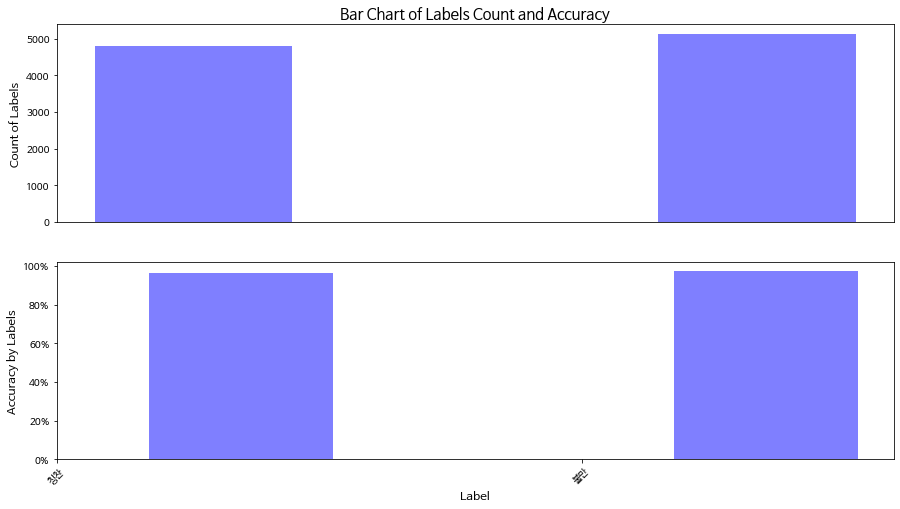

08/11/2021 19:53:35 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 19:53:35 - INFO - __main__ -     acc = 0.9693004529441369


                                              Review  ...                    Softmax
0         수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함  ...   [-0.7596847, 0.48260427]
1                                             경청해주세요  ...  [0.39111328, -0.34469205]
2                                                 실망  ...   [0.4262874, -0.40569994]
3  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...    [-1.2331587, 0.8405062]
4  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...     [-1.109798, 0.7413867]

[5 rows x 4 columns]
{'acc': 0.9693004529441369}


08/11/2021 19:53:37 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-126


loss: 0.437996358031363
loss: 0.4358840496279299
loss: 0.4338605058516643
loss: 0.4319366061916718
loss: 0.43010419356913965
loss: 0.428106421209646
loss: 0.4262029659703262
loss: 0.4242321060442213
loss: 0.4223193019628525
loss: 0.42049459335120287
loss: 0.41862209532817785
loss: 0.41679271461739054
loss: 0.414853047874334
loss: 0.4129233909504754
loss: 0.4110582018574924
loss: 0.409385187000456
loss: 0.4076279225674542
loss: 0.40592436709751684
loss: 0.404479551212541
loss: 0.40299420824197874
loss: 0.4010901341632921
loss: 0.39946862672631805
loss: 0.39797157969250774
loss: 0.3963439667224884
loss: 0.3944800256301236
loss: 0.3928464808942456
loss: 0.391070633785787
loss: 0.38952654624333627
loss: 0.3878836806262693
loss: 0.3864642347758397
loss: 0.3849192586768964
loss: 0.3831302087895478
loss: 0.38168581832879744
loss: 0.38007711078971623
loss: 0.37833154997470214
loss: 0.37674328339872537
loss: 0.3750308786341749
loss: 0.37360506327595655
loss: 0.3719235217029398
loss: 0.370577512

08/11/2021 19:54:54 - INFO - __main__ -   ***** Running evaluation on test dataset (189 step) *****
08/11/2021 19:54:54 - INFO - __main__ -     Num examples = 1987
08/11/2021 19:54:54 - INFO - __main__ -     Eval Batch size = 128


loss: 0.3392820408341115


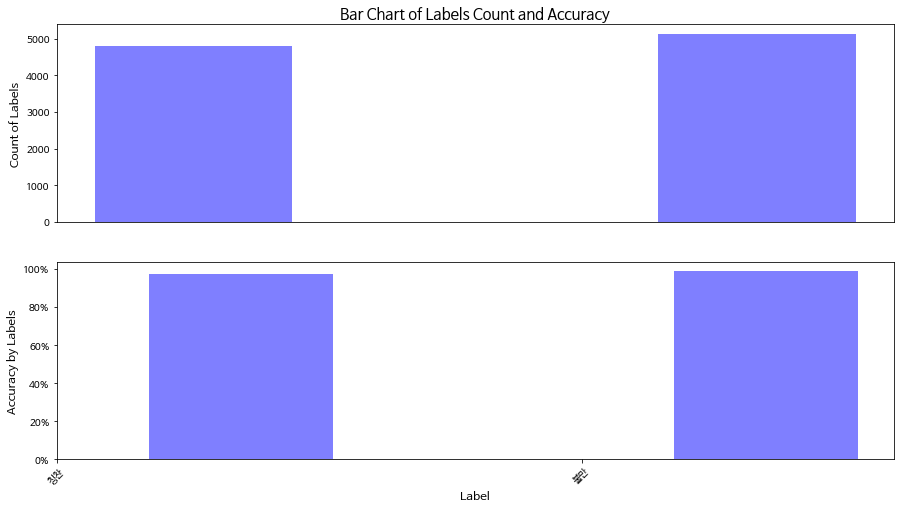

08/11/2021 19:55:04 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 19:55:04 - INFO - __main__ -     acc = 0.9833920483140413


                                              Review  ...                    Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...    [-1.7266343, 1.2623837]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...    [-1.6132615, 1.1607403]
2                       신속한 전화 연결 부탁드립니다 수고하세요 감사합니다  ...  [0.23260169, -0.30634037]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...    [-1.6582874, 1.2050012]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...    [0.6168396, -0.5199491]

[5 rows x 4 columns]
{'acc': 0.9833920483140413}


08/11/2021 19:55:07 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-189


loss: 0.33800094092362803
loss: 0.33673355529445625
loss: 0.3354852905419345
loss: 0.33416034474274037
loss: 0.3328885282821876
loss: 0.33168203368400917
loss: 0.33047494641980346
loss: 0.32932456802141846
loss: 0.3283207347672997
loss: 0.32717661020444266
loss: 0.32609934113919736
loss: 0.3248172501352296
loss: 0.3236709430740021
loss: 0.32253333184813043
loss: 0.3214165730146216
loss: 0.3203187718624022
loss: 0.31941387361114465
loss: 0.3182029846137848
loss: 0.31712305434764576
loss: 0.31604449554350955
loss: 0.3151265886567888
loss: 0.314194366124004
loss: 0.31299020045981657
loss: 0.31181494186811604
loss: 0.3106974989140981
loss: 0.30972897782921793
loss: 0.30861497720427533
loss: 0.3075385602354179
loss: 0.3064970867451998
loss: 0.30549857736518393
loss: 0.3045138569887389
loss: 0.3034320021410603
loss: 0.302585613368465
loss: 0.3014987525885148
loss: 0.30040185772148625
loss: 0.29933870433105364
loss: 0.2983078948527047
loss: 0.2973828097961285
loss: 0.29635716662660505
loss: 0

08/11/2021 19:56:24 - INFO - __main__ -   ***** Running evaluation on test dataset (252 step) *****
08/11/2021 19:56:24 - INFO - __main__ -     Num examples = 1987
08/11/2021 19:56:24 - INFO - __main__ -     Eval Batch size = 128


loss: 0.27724178938106414


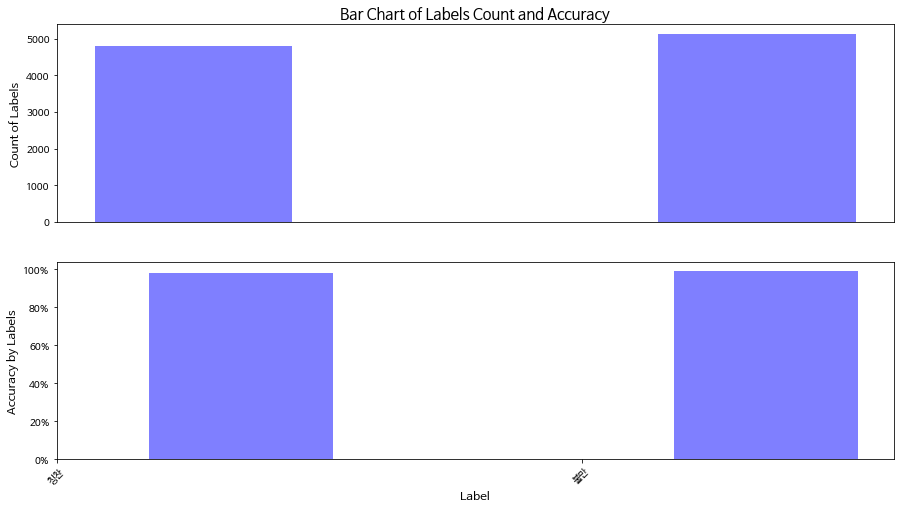

08/11/2021 19:56:33 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 19:56:33 - INFO - __main__ -     acc = 0.9874182184197282


                                              Review  ...                    Softmax
0                                                 실망  ...  [0.03597161, -0.08412377]
1  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...    [-2.0404413, 1.5270624]
2  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...    [-1.8671193, 1.3843119]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...    [-1.8533427, 1.3583615]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...    [1.0767736, -0.9036262]

[5 rows x 4 columns]
{'acc': 0.9874182184197282}


08/11/2021 19:56:35 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-252


loss: 0.2766174140272169
loss: 0.27577434928985095
loss: 0.2749714465994461
loss: 0.2740833347197622
loss: 0.2731988249991654
loss: 0.272340538918741
loss: 0.27147103634637754
loss: 0.27072367274130765
loss: 0.2700571587516202
loss: 0.26919734652886407
loss: 0.2684243387000869
loss: 0.2676031958086021
loss: 0.2667847365984377
loss: 0.2660898177471376
loss: 0.2652517312977198
loss: 0.26457042655726865
loss: 0.2637413174301718
loss: 0.26297145376878756
loss: 0.26218431517206875
loss: 0.26146279609597783
loss: 0.26069169496987765
loss: 0.25995646301575387
loss: 0.25929802484133024
loss: 0.2585106701657608
loss: 0.25771626753443416
loss: 0.2571449428662765
loss: 0.2565275250556862
loss: 0.2557732511710908
loss: 0.2550153696240055
loss: 0.2542853772058977
loss: 0.25371196515884503
loss: 0.2530821252509322
loss: 0.25243497992816727
loss: 0.2516769859809559
loss: 0.25100929073288464
loss: 0.25027021769589436
loss: 0.2496897470605621
loss: 0.24899564181165448
loss: 0.2483079227078002
loss: 0.2

08/11/2021 19:57:52 - INFO - __main__ -   ***** Running evaluation on test dataset (315 step) *****
08/11/2021 19:57:52 - INFO - __main__ -     Num examples = 1987
08/11/2021 19:57:52 - INFO - __main__ -     Eval Batch size = 128


loss: 0.23381302294040482


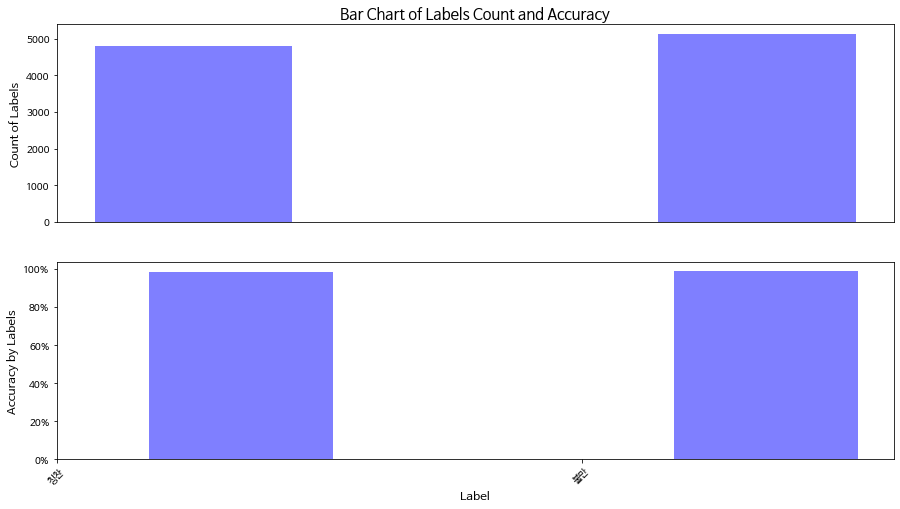

08/11/2021 19:58:02 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 19:58:02 - INFO - __main__ -     acc = 0.9879214896829391


                                              Review  ...                    Softmax
0                                                 실망  ...  [0.07747592, -0.11728798]
1  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...      [-2.2402043, 1.70273]
2  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...    [-1.9064368, 1.4177557]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...     [-1.993448, 1.4777527]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...     [1.377998, -1.1658238]

[5 rows x 4 columns]
{'acc': 0.9879214896829391}


08/11/2021 19:58:04 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-315


loss: 0.2332004952963583
loss: 0.2326927092337646
loss: 0.23215020307392445
loss: 0.23152926703185123
loss: 0.23105955339269713
loss: 0.23045981754302236
loss: 0.22991687713063652
loss: 0.2293890404281417
loss: 0.22877427149724996
loss: 0.2282128811856875
loss: 0.22762307704660606
loss: 0.22711255854217832
loss: 0.22660779587856336
loss: 0.22607471738973106
loss: 0.22558649229167987
loss: 0.2251245522775949
loss: 0.22455547998535885
loss: 0.22397413362634253
loss: 0.2234698367098759
loss: 0.22290766176336738
loss: 0.22241198257654018
loss: 0.22195920586387022
loss: 0.22152484143869236
loss: 0.22105133404356364
loss: 0.2205264242092038
loss: 0.21997845305616032
loss: 0.2194353117721907
loss: 0.2188756626436036
loss: 0.21832383633049768
loss: 0.21786030238305312
loss: 0.21738901427500165
loss: 0.21685400195097718
loss: 0.2163659880986844
loss: 0.21582155634134068
loss: 0.21530402395342077
loss: 0.21482149225014907
loss: 0.21436841138215226
loss: 0.213921416793599
loss: 0.2134298431124054

08/11/2021 19:59:21 - INFO - __main__ -   ***** Running evaluation on test dataset (378 step) *****
08/11/2021 19:59:21 - INFO - __main__ -     Num examples = 1987
08/11/2021 19:59:21 - INFO - __main__ -     Eval Batch size = 128


loss: 0.2027566230230073


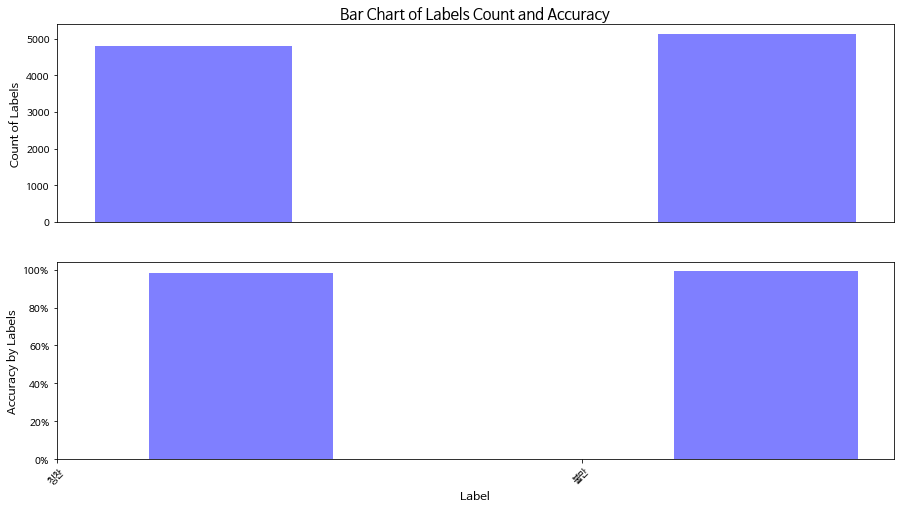

08/11/2021 19:59:30 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 19:59:30 - INFO - __main__ -     acc = 0.9889280322093609


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-2.4119844, 1.8513454]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...  [-2.0595908, 1.5504622]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...  [-2.1311462, 1.5927422]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...  [1.3839698, -1.1848774]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.4056302, -1.3337369]

[5 rows x 4 columns]
{'acc': 0.9889280322093609}


08/11/2021 19:59:33 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-378


loss: 0.20235597788501225
loss: 0.20196147071883866
loss: 0.20149821483498326
loss: 0.2010710632857618
loss: 0.20062307850032188
loss: 0.20023281992568323
loss: 0.19980207668109373
loss: 0.19936607734642808
loss: 0.19893271739784754
loss: 0.19848198632796094
loss: 0.19810939962307714
loss: 0.1977474066787041
loss: 0.1973078965550036
loss: 0.19686145514572914
loss: 0.1964205937180431
loss: 0.19600517316461366
loss: 0.19558610368189933
loss: 0.19525019507478886
loss: 0.19481532392033402
loss: 0.19439897172845638
loss: 0.19409445088291377
loss: 0.19371217667590826
loss: 0.19334592908490775
loss: 0.19298346108520653
loss: 0.19258276672188018
loss: 0.19216140480435426
loss: 0.1917642043788492
loss: 0.19134906697743045
loss: 0.19095681109797458
loss: 0.19060438868644483
loss: 0.1902028253270099
loss: 0.1897970116583676
loss: 0.1893870245910039
loss: 0.18901956632950354
loss: 0.18873947792061882
loss: 0.18836316537417938
loss: 0.18796233695045292
loss: 0.18767166315452555
loss: 0.187331803335

08/11/2021 20:00:50 - INFO - __main__ -   ***** Running evaluation on test dataset (441 step) *****
08/11/2021 20:00:50 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:00:50 - INFO - __main__ -     Eval Batch size = 128


loss: 0.17914441895255157


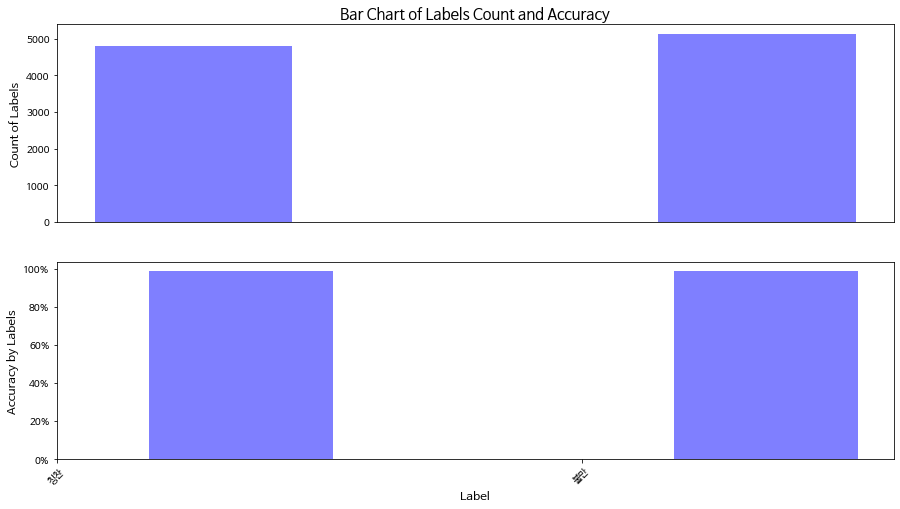

08/11/2021 20:00:59 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:00:59 - INFO - __main__ -     acc = 0.9869149471565174


                                              Review  ...                   Softmax
0                                                 실망  ...  [0.13317612, -0.1667776]
1  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...   [-2.5331182, 1.9550806]
2  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...   [-1.5722805, 1.1338903]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...    [-2.107348, 1.5689833]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...   [1.7384276, -1.4826151]

[5 rows x 4 columns]
{'acc': 0.9869149471565174}


08/11/2021 20:01:02 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-441


loss: 0.17888565353071528
loss: 0.17861322708781094
loss: 0.17825336152318497
loss: 0.17790006065971395
loss: 0.1775541008938722
loss: 0.17725020730388777
loss: 0.17690487230928348
loss: 0.17657814479800135
loss: 0.1762267440888617
loss: 0.1758787190777037
loss: 0.175609727608518
loss: 0.17526864127212802
loss: 0.17492590757242776
loss: 0.1745831772889737
loss: 0.17424169015711205
loss: 0.17390938643243825
loss: 0.17358544187042782
loss: 0.17339366857441293
loss: 0.17306575530978
loss: 0.17286170654225116
loss: 0.17253102444402582
loss: 0.17227364547116195
loss: 0.17193958550242
loss: 0.1716076574899176
loss: 0.1712750523618938
loss: 0.1709487661360354
loss: 0.1706393773858555
loss: 0.17031535142059648
loss: 0.17005251651193867
loss: 0.169840476714913
loss: 0.16952741127934748
loss: 0.16920697837910492
loss: 0.16889568452845144
loss: 0.16857463217879595
loss: 0.1682890514224893
loss: 0.16797504613109604
loss: 0.1677171208322921
loss: 0.16740597742133326
loss: 0.16710321687860413
loss: 

08/11/2021 20:02:19 - INFO - __main__ -   ***** Running evaluation on test dataset (504 step) *****
08/11/2021 20:02:19 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:02:19 - INFO - __main__ -     Eval Batch size = 128


loss: 0.16072322194102323


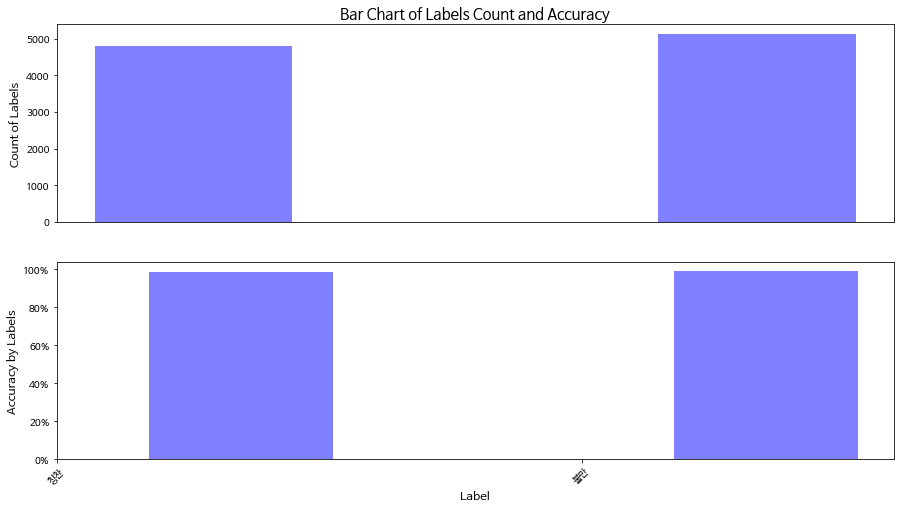

08/11/2021 20:02:28 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:02:28 - INFO - __main__ -     acc = 0.98842476094615


                                              Review  ...                   Softmax
0                                                 실망  ...  [0.16038221, -0.1915624]
1  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...    [-2.6518326, 2.066124]
2  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...    [-2.167226, 1.6515343]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...   [-2.2596195, 1.7045293]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...   [1.7222847, -1.4704901]

[5 rows x 4 columns]
{'acc': 0.98842476094615}


08/11/2021 20:02:31 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-504


loss: 0.1605073756234038
loss: 0.16032421605278674
loss: 0.1600471252384476
loss: 0.15976677368043035
loss: 0.15948281714542675
loss: 0.1592019559413779
loss: 0.15892377180100187
loss: 0.15864388082445657
loss: 0.15837564395076176
loss: 0.1581110832071229
loss: 0.15783828054057453
loss: 0.15756194889653735
loss: 0.15728592765616609
loss: 0.15702943586201396
loss: 0.15675596765427346
loss: 0.1565038857730822
loss: 0.15623376989690677
loss: 0.15603096854526877
loss: 0.15578237965161668
loss: 0.15558455003610322
loss: 0.15538208303706988
loss: 0.15512001422010788
loss: 0.15485437264033297
loss: 0.15465711206233015
loss: 0.15439573456207553
loss: 0.15419311618854134
loss: 0.15393090973873036
loss: 0.15367808185965942
loss: 0.1534158484748168
loss: 0.153172595032285
loss: 0.15291421864112126
loss: 0.15266027180443226
loss: 0.1524442453370941
loss: 0.15223658414986885
loss: 0.1519887060607768
loss: 0.15173996820252528
loss: 0.151486044548204
loss: 0.15123397071340647
loss: 0.1509814522765974

08/11/2021 20:03:47 - INFO - __main__ -   ***** Running evaluation on test dataset (567 step) *****
08/11/2021 20:03:47 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:03:47 - INFO - __main__ -     Eval Batch size = 128


loss: 0.14595289696566432


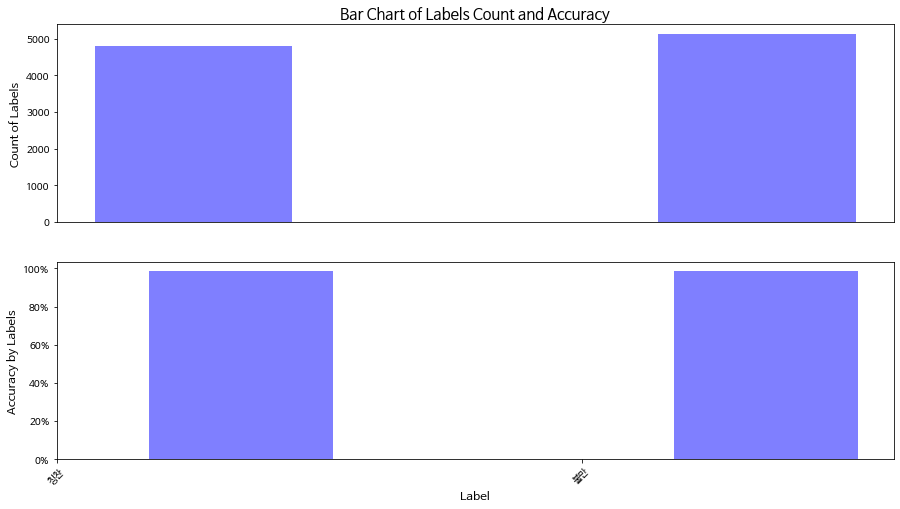

08/11/2021 20:03:57 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:03:57 - INFO - __main__ -     acc = 0.9854051333668847


                                              Review  ...                    Softmax
0                                             경청해주세요  ...     [0.588792, -0.5822917]
1                                                 실망  ...  [0.07089633, -0.11325842]
2  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...    [-2.7413702, 2.1501598]
3  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...    [-2.0906873, 1.5913128]
4                       신속한 전화 연결 부탁드립니다 수고하세요 감사합니다  ...   [0.72974217, -0.7954066]

[5 rows x 4 columns]
{'acc': 0.9854051333668847}


08/11/2021 20:03:59 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-567


loss: 0.14572177966236805
loss: 0.14549452644692626
loss: 0.1452663404654646
loss: 0.14503579485293758
loss: 0.14481123112194189
loss: 0.14458335925504748
loss: 0.14442022083625716
loss: 0.14432695107453544
loss: 0.14411905874375305
loss: 0.14389657702271147
loss: 0.1437472128341535
loss: 0.1435237873686616
loss: 0.14329886541316478
loss: 0.14307862630020987
loss: 0.14285574566502496
loss: 0.14263163025508513
loss: 0.14240823189842783
loss: 0.1421864057262229
loss: 0.14196542458793104
loss: 0.14175775062984564
loss: 0.14154924599289084
loss: 0.14137410044872498
loss: 0.1411547793533211
loss: 0.14093626679792723
loss: 0.14071998610066855
loss: 0.14050901425974113
loss: 0.14035336380849533
loss: 0.1401389295423106
loss: 0.1399788636098547
loss: 0.13977321269305756
loss: 0.1395666139078853
loss: 0.13935732329497502
loss: 0.13914450560075542
loss: 0.1389331566309324
loss: 0.13879894029868897
loss: 0.13864876733626397
loss: 0.13845739803209112
loss: 0.1382478488901676
loss: 0.13810942110239

08/11/2021 20:05:16 - INFO - __main__ -   ***** Running evaluation on test dataset (630 step) *****
08/11/2021 20:05:16 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:05:16 - INFO - __main__ -     Eval Batch size = 128


loss: 0.13387622323094142


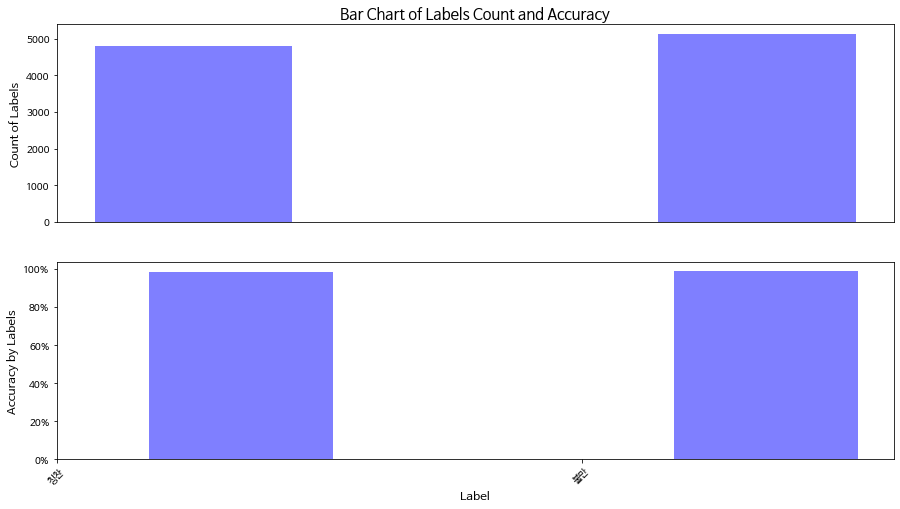

08/11/2021 20:05:25 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:05:25 - INFO - __main__ -     acc = 0.9879214896829391


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...   [-2.8182266, 2.219689]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...  [-2.2264395, 1.7144965]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...   [-2.377601, 1.8215023]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...  [2.0404792, -1.7595426]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...   [1.706535, -1.6220582]

[5 rows x 4 columns]
{'acc': 0.9879214896829391}


08/11/2021 20:05:27 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-630


loss: 0.13372053576872436
loss: 0.1335272218345346
loss: 0.13338820146482092
loss: 0.1331952327145528
loss: 0.13304473027058944
loss: 0.13285338578001837
loss: 0.13271475746332898
loss: 0.13252495644106108
loss: 0.13238482733136145
loss: 0.13219639175222256
loss: 0.13206599194225208
loss: 0.13187923744129382
loss: 0.13169189140745213
loss: 0.13155179114156165
loss: 0.13136472242573896
loss: 0.13118179171741148
loss: 0.13104434480525012
loss: 0.13086944671468465
loss: 0.1307006966400151
loss: 0.13051638873437277
loss: 0.13033309614946764
loss: 0.1301525711207622
loss: 0.12996957172421456
loss: 0.12978779401954846
loss: 0.12960656359365197
loss: 0.12948412581193602
loss: 0.1293036524203565
loss: 0.12913278482520335
loss: 0.1289531501428378
loss: 0.12877377131671616
loss: 0.12871085711488564
loss: 0.1285336187596115
loss: 0.12835599861471586
loss: 0.12818681382355337
loss: 0.12803039661279522
loss: 0.12795344809092604
loss: 0.12778016148523233
loss: 0.12760458493878518
loss: 0.12747197583

08/11/2021 20:06:44 - INFO - __main__ -   ***** Running evaluation on test dataset (693 step) *****
08/11/2021 20:06:44 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:06:44 - INFO - __main__ -     Eval Batch size = 128


loss: 0.12394473733028336


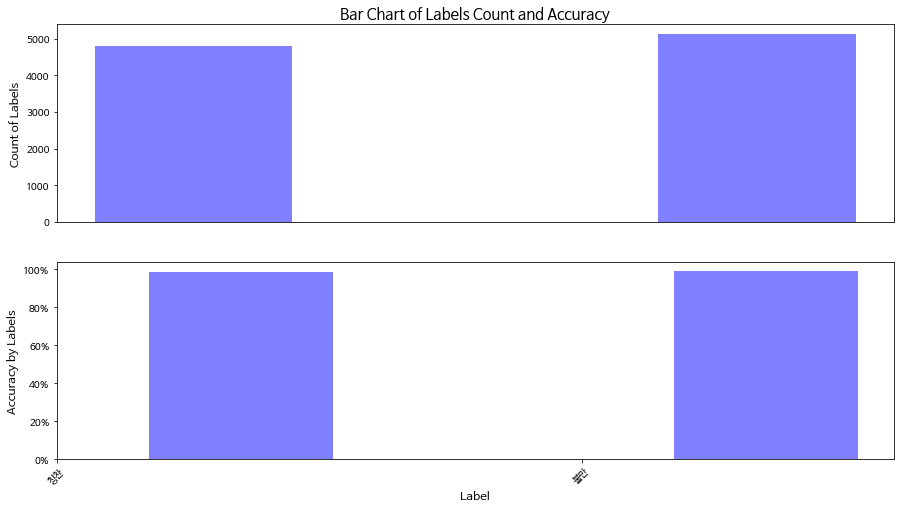

08/11/2021 20:06:54 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:06:54 - INFO - __main__ -     acc = 0.98842476094615


                                              Review  ...                       Softmax
0                                                 실망  ...  [-0.008833947, -0.048738077]
1  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...       [-2.8731842, 2.2687182]
2  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...       [-2.1650956, 1.6654404]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...       [-2.3653073, 1.8103384]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...       [2.0549045, -1.7695811]

[5 rows x 4 columns]
{'acc': 0.98842476094615}


08/11/2021 20:06:56 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-693


loss: 0.12378204855209039
loss: 0.12364115414591573
loss: 0.12352594417712555
loss: 0.1233627892592374
loss: 0.12320247004182214
loss: 0.1230444105112864
loss: 0.1228922219827239
loss: 0.12274269799113316
loss: 0.12258205445154313
loss: 0.12247081821225318
loss: 0.12231176306191958
loss: 0.12215279779192192
loss: 0.12204692367511794
loss: 0.12188963992376266
loss: 0.1217750305886049
loss: 0.12161636583596384
loss: 0.12153980985782306
loss: 0.12142484289700095
loss: 0.12137014745718935
loss: 0.12121570199404073
loss: 0.12110593902724547
loss: 0.12094987563372075
loss: 0.120801493400635
loss: 0.12064852436284848
loss: 0.12054169420957109
loss: 0.12038806355681389
loss: 0.12025111811494248
loss: 0.12017145599193364
loss: 0.12001912938069728
loss: 0.11986858110596654
loss: 0.11971851683206321
loss: 0.11956659785889347
loss: 0.1194192962618365
loss: 0.1192729535667633
loss: 0.11917606220135445
loss: 0.11902900610952057
loss: 0.11888010787509688
loss: 0.11873247821607644
loss: 0.118583809639

08/11/2021 20:08:13 - INFO - __main__ -   ***** Running evaluation on test dataset (756 step) *****
08/11/2021 20:08:13 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:08:13 - INFO - __main__ -     Eval Batch size = 128


loss: 0.11536541630430196


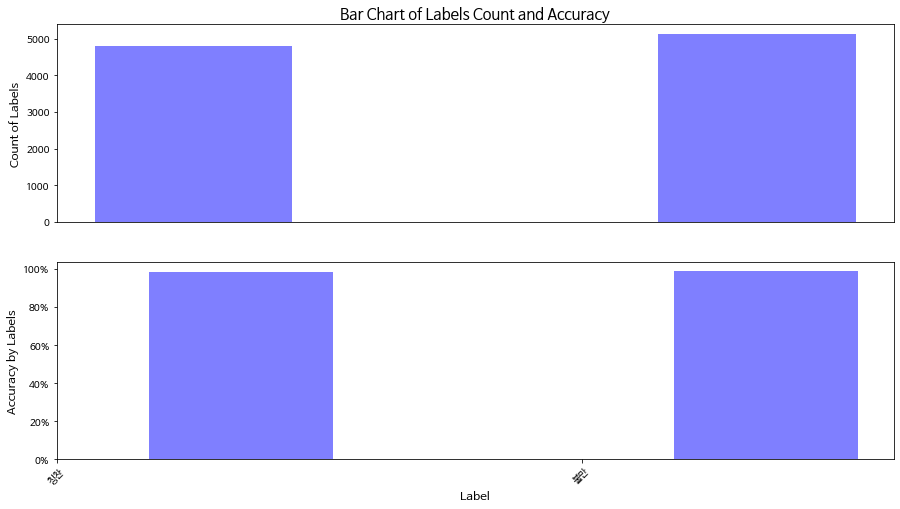

08/11/2021 20:08:23 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:08:23 - INFO - __main__ -     acc = 0.9879214896829391


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-2.9245584, 2.3148265]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...   [-1.880687, 1.4150059]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...  [-2.3099272, 1.7598721]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...   [2.133413, -1.8373194]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.8659338, -1.7550195]

[5 rows x 4 columns]
{'acc': 0.9879214896829391}


08/11/2021 20:08:25 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-756


loss: 0.1152283739276437
loss: 0.11518221751646701
loss: 0.11504199678306523
loss: 0.1149030171212201
loss: 0.1147691639832927
loss: 0.11463230210808631
loss: 0.11449487055596916
loss: 0.11435736275000098
loss: 0.11422259959520079
loss: 0.11408598156033117
loss: 0.1139495918524817
loss: 0.11381312717761223
loss: 0.11376829117885337
loss: 0.11363283218936873
loss: 0.11349658023725456
loss: 0.11336150037612129
loss: 0.11322715841980716
loss: 0.11309254200628523
loss: 0.11300240955405658
loss: 0.11287015847760953
loss: 0.11279867934075063
loss: 0.11271338663147738
loss: 0.11268274967507273
loss: 0.11254980372838103
loss: 0.112417321348093
loss: 0.11228498494814691
loss: 0.11216930989746961
loss: 0.1120388786728988
loss: 0.11190680243834189
loss: 0.11182241949653277
loss: 0.11169172259665354
loss: 0.11156317118323658
loss: 0.11147431989468361
loss: 0.11134372047985656
loss: 0.11121340533165089
loss: 0.11108414100652392
loss: 0.11100104269847594
loss: 0.11087239084891994
loss: 0.11074327212

08/11/2021 20:09:41 - INFO - __main__ -   ***** Running evaluation on test dataset (819 step) *****
08/11/2021 20:09:41 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:09:41 - INFO - __main__ -     Eval Batch size = 128


loss: 0.10800958928960275


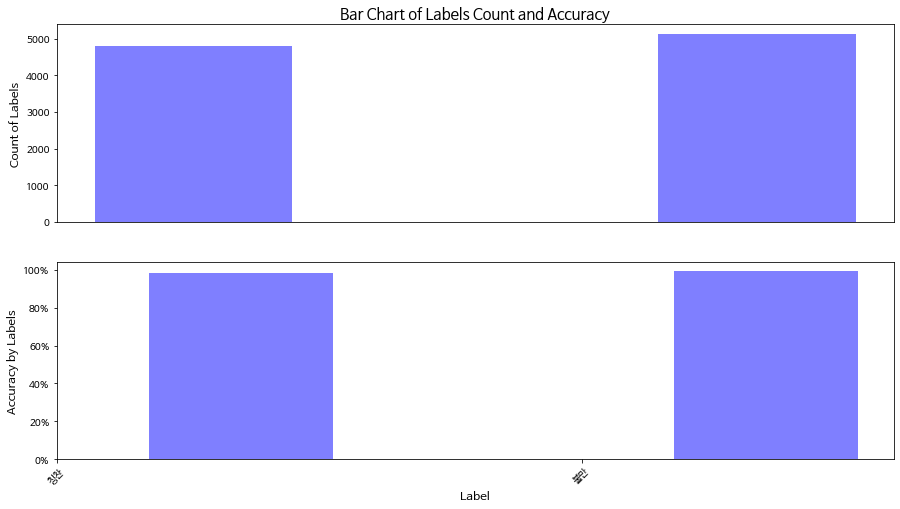

08/11/2021 20:09:51 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:09:51 - INFO - __main__ -     acc = 0.9894313034725717


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-2.9794943, 2.3678358]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...  [-2.1826594, 1.6845412]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...  [-2.4647255, 1.9035331]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...   [2.162111, -1.8662224]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.7798603, -1.6921046]

[5 rows x 4 columns]
{'acc': 0.9894313034725717}


08/11/2021 20:09:53 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-819


loss: 0.10788895730099572
loss: 0.10776709665994678
loss: 0.10768959837752665
loss: 0.1075685365710584
loss: 0.10749056491519333
loss: 0.10737010678953746
loss: 0.10729103528141308
loss: 0.10717106626471538
loss: 0.1070564220674057
loss: 0.1069366873210505
loss: 0.10685748024170388
loss: 0.10673879717211054
loss: 0.10662723228709253
loss: 0.10652717771254579
loss: 0.10641596706001182
loss: 0.10629964869101337
loss: 0.10618241621196965
loss: 0.10606581411461302
loss: 0.10595730397803597
loss: 0.10584048181827733
loss: 0.10572599639417604
loss: 0.10562637550025451
loss: 0.1055118352967821
loss: 0.10539686633715868
loss: 0.10530168862883178
loss: 0.10518651663452475
loss: 0.10509121792895133
loss: 0.10497679997624779
loss: 0.10486330696049954
loss: 0.1047505837737926
loss: 0.10463705817840117
loss: 0.10456953790273023
loss: 0.10445704861891679
loss: 0.10438857351430852
loss: 0.1042777038112815
loss: 0.10425646515584916
loss: 0.10414400983603984
loss: 0.10403282924032528
loss: 0.1039564304

08/11/2021 20:11:10 - INFO - __main__ -   ***** Running evaluation on test dataset (882 step) *****
08/11/2021 20:11:10 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:11:10 - INFO - __main__ -     Eval Batch size = 128


loss: 0.1016067214111656


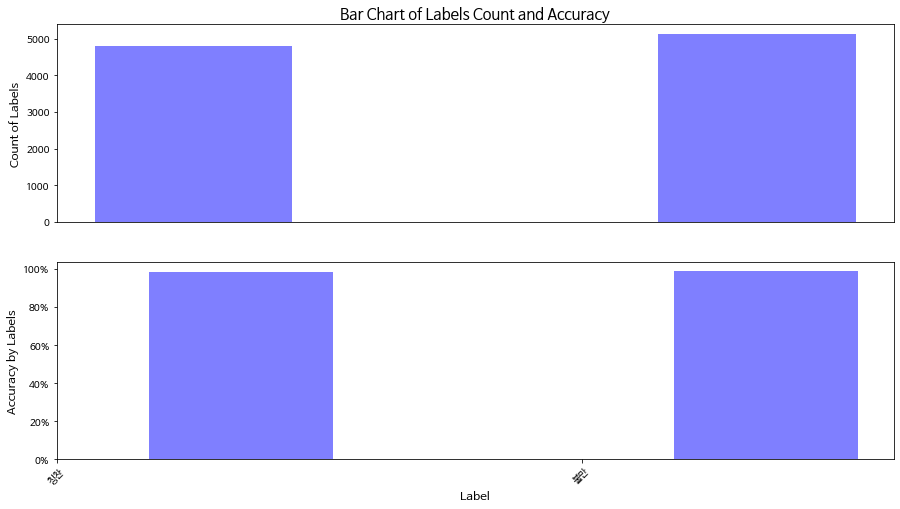

08/11/2021 20:11:19 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:11:19 - INFO - __main__ -     acc = 0.9874182184197282


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-3.0185363, 2.4041796]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...  [-2.2234797, 1.7276386]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...  [-2.5201597, 1.9583786]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...   [2.193275, -1.8917375]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.9660128, -1.8446243]

[5 rows x 4 columns]
{'acc': 0.9874182184197282}


08/11/2021 20:11:22 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-882


loss: 0.10150322083400674
loss: 0.10140065923312097
loss: 0.10130253993185226
loss: 0.10119717153373677
loss: 0.10109143219247729
loss: 0.10102102689199603
loss: 0.1009596741875619
loss: 0.10085689062723534
loss: 0.10075945426437138
loss: 0.10065491038328662
loss: 0.10055111775180994
loss: 0.10044998774863363
loss: 0.1003464581663382
loss: 0.10028695198707283
loss: 0.10022397265419647
loss: 0.1001228411901817
loss: 0.1000196980483399
loss: 0.09991652624681592
loss: 0.09982164790822848
loss: 0.0997205372443402
loss: 0.09966648265137724
loss: 0.09956516127052627
loss: 0.09946321926712579
loss: 0.09937518859070378
loss: 0.09927490126811864
loss: 0.09917378358159312
loss: 0.09911324764367263
loss: 0.09904928926102162
loss: 0.09896911968018055
loss: 0.0988798807543629
loss: 0.0987979731500059
loss: 0.09878932289968712
loss: 0.09868965203481946
loss: 0.09858977748182761
loss: 0.09851928972491879
loss: 0.09841993668731423
loss: 0.09834474132531064
loss: 0.09824638274174345
loss: 0.09814782045

08/11/2021 20:12:39 - INFO - __main__ -   ***** Running evaluation on test dataset (945 step) *****
08/11/2021 20:12:39 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:12:39 - INFO - __main__ -     Eval Batch size = 128


loss: 0.09596730174654454


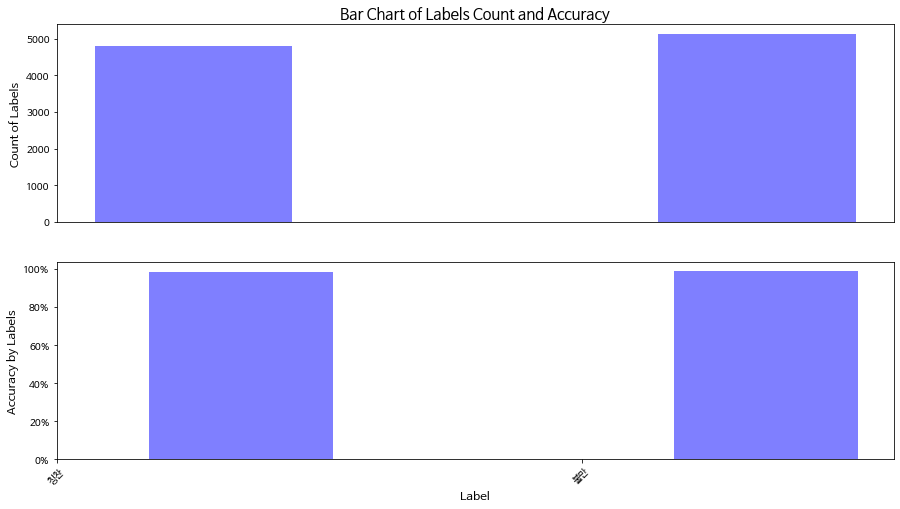

08/11/2021 20:12:48 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:12:48 - INFO - __main__ -     acc = 0.9879214896829391


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-3.0493028, 2.4298859]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...  [-1.8871962, 1.4290974]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...  [-2.5069706, 1.9416729]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...    [2.2907898, -1.97815]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.9206394, -1.8109787]

[5 rows x 4 columns]
{'acc': 0.9879214896829391}


08/11/2021 20:12:51 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-945


loss: 0.09587443115762642
loss: 0.09578083507045947
loss: 0.09568786411153207
loss: 0.09563447007746509
loss: 0.09556428930771194
loss: 0.09555487643700136
loss: 0.09546206836704117
loss: 0.09540454676601516
loss: 0.09531245064048928
loss: 0.09525905155250071
loss: 0.09520666098327349
loss: 0.09511452237223912
loss: 0.0950959082002633
loss: 0.09500470777489906
loss: 0.09491373873412765
loss: 0.09482274093867728
loss: 0.09473150544131868
loss: 0.09464131366182989
loss: 0.09455076714444334
loss: 0.09446006646630754
loss: 0.094370479365294
loss: 0.09428078967080121
loss: 0.09419127635865603
loss: 0.09410092531981175
loss: 0.09401189680595297
loss: 0.09392245249471691
loss: 0.09383520290615811
loss: 0.0937485312372982
loss: 0.09365916858404279
loss: 0.09357092498156887
loss: 0.09348294008513683
loss: 0.09339788788834257
loss: 0.0933097019783985
loss: 0.09322199463678774
loss: 0.09313397918428694
loss: 0.09304598813485374
loss: 0.09295921441871301
loss: 0.09287303523989518
loss: 0.092785542

08/11/2021 20:14:07 - INFO - __main__ -   ***** Running evaluation on test dataset (1008 step) *****
08/11/2021 20:14:07 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:14:07 - INFO - __main__ -     Eval Batch size = 128


loss: 0.09088381126085074


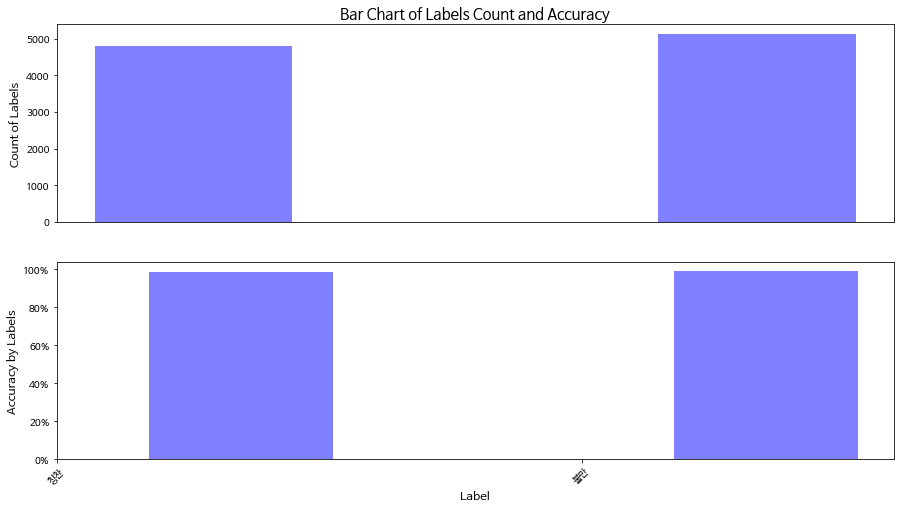

08/11/2021 20:14:17 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:14:17 - INFO - __main__ -     acc = 0.98842476094615


                                              Review  ...                   Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...   [-3.0975533, 2.4766755]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...    [-2.6302583, 2.090394]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...    [-2.697497, 2.1174128]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...    [2.144528, -1.8490653]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [0.83005947, -0.9078663]

[5 rows x 4 columns]
{'acc': 0.98842476094615}


08/11/2021 20:14:19 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-1008


loss: 0.0908006997137516
loss: 0.0907540168129092
loss: 0.0906715103568791
loss: 0.09058965891995376
loss: 0.0905073581402248
loss: 0.0904251056276923
loss: 0.09038901804519697
loss: 0.09030868094432806
loss: 0.09026542439371817
loss: 0.09023327421495775
loss: 0.09015122056555759
loss: 0.09007013234967257
loss: 0.08998895467584633
loss: 0.08990836526730157
loss: 0.08982710151469749
loss: 0.08974625388145796
loss: 0.08966587439860876
loss: 0.08958743530921057
loss: 0.08950731236289937
loss: 0.08942681419434831
loss: 0.0893462337467519
loss: 0.08928218919973711
loss: 0.08923404466742009
loss: 0.08919100590319148
loss: 0.08911147635404854
loss: 0.08903416777227788
loss: 0.08895478833484764
loss: 0.08887527341923845
loss: 0.08879603231110203
loss: 0.08871713757599294
loss: 0.08863982267066463
loss: 0.08859762754246521
loss: 0.08851888474286333
loss: 0.08844310362758954
loss: 0.08836515248089685
loss: 0.08828962904979186
loss: 0.08821173318835537
loss: 0.08813347782490928
loss: 0.0880560621

08/11/2021 20:15:36 - INFO - __main__ -   ***** Running evaluation on test dataset (1071 step) *****
08/11/2021 20:15:36 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:15:36 - INFO - __main__ -     Eval Batch size = 128


loss: 0.08646199506699663


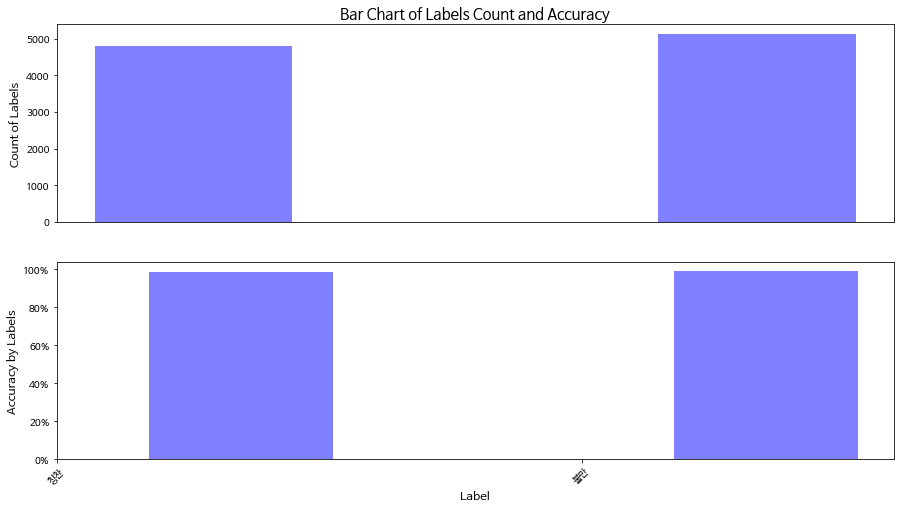

08/11/2021 20:15:46 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:15:46 - INFO - __main__ -     acc = 0.98842476094615


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-3.1157012, 2.4907331]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...  [-2.4697466, 1.9419267]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...    [-2.64458, 2.0632663]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...  [2.2353625, -1.9280717]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.3486145, -1.3431752]

[5 rows x 4 columns]
{'acc': 0.98842476094615}


08/11/2021 20:15:48 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-1071


loss: 0.08638751628780876
loss: 0.08631732064591788
loss: 0.08624287961168801
loss: 0.08616888715950556
loss: 0.08611539287880396
loss: 0.08604147520042547
loss: 0.08600274516927883
loss: 0.08593110529277767
loss: 0.08585832465603879
loss: 0.08582336266346752
loss: 0.08574990207560071
loss: 0.0856772631278652
loss: 0.0856205815482864
loss: 0.08554752427174749
loss: 0.08547601967271329
loss: 0.08540487149173416
loss: 0.08535084046632298
loss: 0.08530741926672619
loss: 0.08524364862813179
loss: 0.0851711963737037
loss: 0.08513501088259462
loss: 0.08506317716006663
loss: 0.08500030821179069
loss: 0.08496032875184327
loss: 0.08488963030951682
loss: 0.08481871900331218
loss: 0.08474728216303475
loss: 0.0846774049172749
loss: 0.08460621505002068
loss: 0.0845431778778734
loss: 0.08450710360499981
loss: 0.08443671651648954
loss: 0.08436767271748555
loss: 0.08429716802096812
loss: 0.08426250406763235
loss: 0.08420032417896357
loss: 0.08413141476963765
loss: 0.08406122572001194
loss: 0.083996478

08/11/2021 20:17:05 - INFO - __main__ -   ***** Running evaluation on test dataset (1134 step) *****
08/11/2021 20:17:05 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:17:05 - INFO - __main__ -     Eval Batch size = 128


loss: 0.08250325639868514


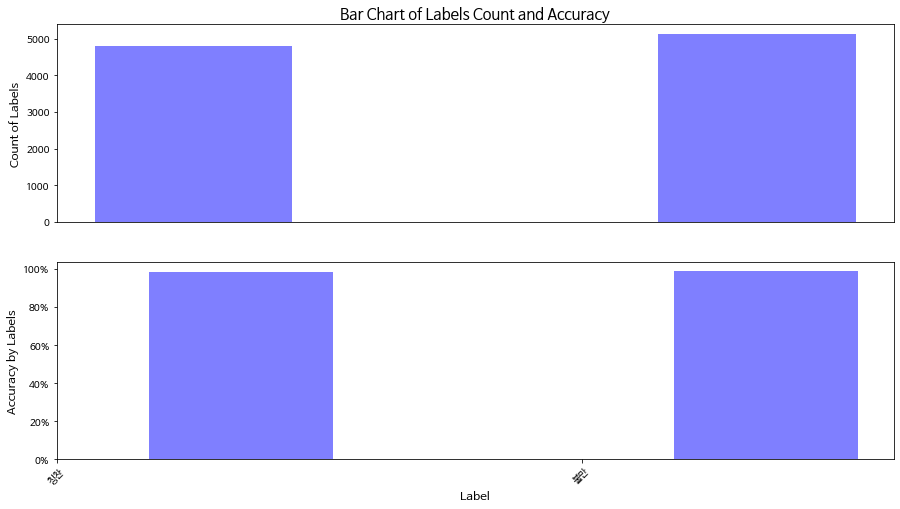

08/11/2021 20:17:14 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:17:14 - INFO - __main__ -     acc = 0.9879214896829391


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-3.1262307, 2.5000918]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...   [-2.253083, 1.7501343]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...   [-2.6100142, 2.031107]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...  [2.2885873, -1.9745859]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.7961277, -1.7117131]

[5 rows x 4 columns]
{'acc': 0.9879214896829391}


08/11/2021 20:17:17 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-1134


loss: 0.08249228688834916
loss: 0.08242751889727669
loss: 0.08236626863050403
loss: 0.08233306621183333
loss: 0.08226624136967249
loss: 0.08219985876665369
loss: 0.08213322628885311
loss: 0.08206702347179376
loss: 0.08200082150984585
loss: 0.08193531550037172
loss: 0.08186958162886737
loss: 0.08180351529016856
loss: 0.08173749123967099
loss: 0.08167177268534327
loss: 0.0816061334600194
loss: 0.08154076956495966
loss: 0.08147565778959817
loss: 0.0814171237264721
loss: 0.0813563651133067
loss: 0.08129177006781489
loss: 0.08122910830913942
loss: 0.08118304069505225
loss: 0.0811183483222324
loss: 0.0810543049894119
loss: 0.08102266138581828
loss: 0.08095816494495575
loss: 0.08089423986331501
loss: 0.0808304912841874
loss: 0.08076682392073761
loss: 0.08070275994718612
loss: 0.08066513847655621
loss: 0.080604773008394
loss: 0.08054082675086016
loss: 0.08047712807924716
loss: 0.08041360029007465
loss: 0.0803515643840576
loss: 0.08028978461170622
loss: 0.08022704571461681
loss: 0.0801938878724

08/11/2021 20:18:34 - INFO - __main__ -   ***** Running evaluation on test dataset (1197 step) *****
08/11/2021 20:18:34 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:18:34 - INFO - __main__ -     Eval Batch size = 128


loss: 0.07897602022238816


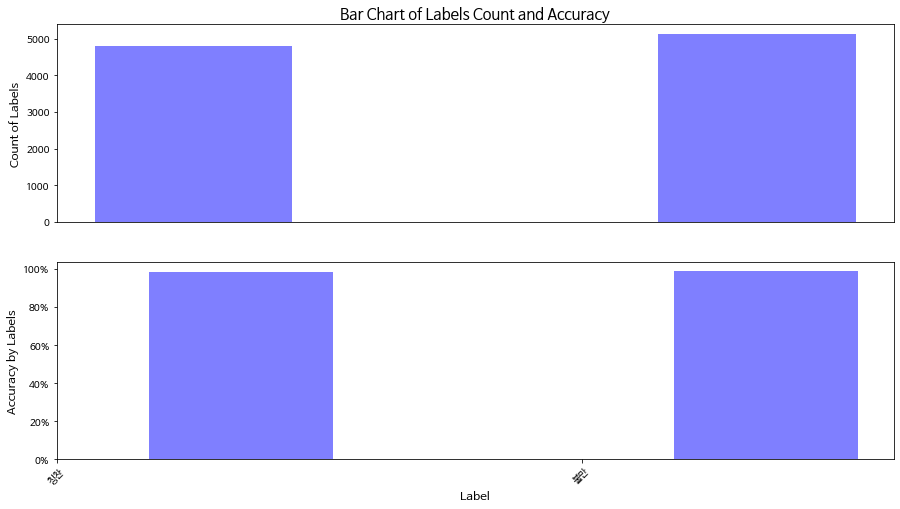

08/11/2021 20:18:44 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:18:44 - INFO - __main__ -     acc = 0.9879214896829391


                                              Review  ...                  Softmax
0  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...  [-3.1372755, 2.5101235]
1  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...   [-2.296737, 1.7887437]
2     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...  [-2.6248555, 2.0440826]
3  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...  [2.2742832, -1.9611424]
4                               기다리는 시간이 불편하지 산 괜찮아요  ...  [1.7929833, -1.7099849]

[5 rows x 4 columns]
{'acc': 0.9879214896829391}


08/11/2021 20:18:46 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-1197


loss: 0.07891553139216104
loss: 0.07885470514840526
loss: 0.07882394631199229
loss: 0.07876347631005125
loss: 0.07872821506540509
loss: 0.07866837417068934
loss: 0.07860808314962864
loss: 0.07854822000712774
loss: 0.07848832996331996
loss: 0.07842844450235206
loss: 0.07836910420743477
loss: 0.07830954376512612
loss: 0.07825058594130534
loss: 0.0781908826379553
loss: 0.07814263278947338
loss: 0.0780836705291937
loss: 0.07802461468402903
loss: 0.07801283186056303
loss: 0.07795378951031078
loss: 0.07791383198524413
loss: 0.07785803294084563
loss: 0.07780341678807073
loss: 0.07775235198453435
loss: 0.07769406867464493
loss: 0.07763537411302109
loss: 0.07762886718211
loss: 0.07759174048745383
loss: 0.07753439042945297
loss: 0.07747672643621877
loss: 0.07741927140989716
loss: 0.07736137540326894
loss: 0.07730376645634701
loss: 0.07724584728418811
loss: 0.07718808548093738
loss: 0.0771304348653013
loss: 0.07707282489079556
loss: 0.07703148995901984
loss: 0.07700789365314159
loss: 0.0769828446

08/11/2021 20:20:03 - INFO - __main__ -   ***** Running evaluation on test dataset (1260 step) *****
08/11/2021 20:20:03 - INFO - __main__ -     Num examples = 1987
08/11/2021 20:20:03 - INFO - __main__ -     Eval Batch size = 128


loss: 0.0758101148072571


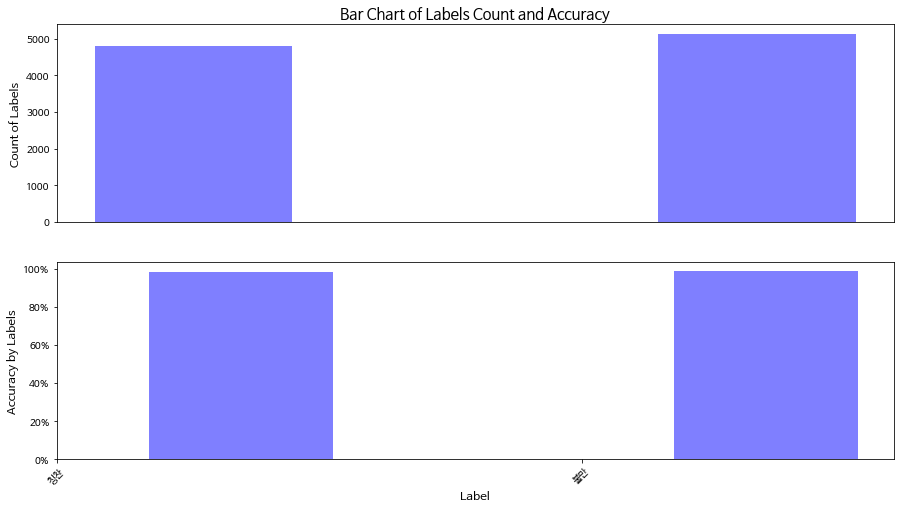

08/11/2021 20:20:12 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 20:20:12 - INFO - __main__ -     acc = 0.9874182184197282


                                              Review  ...                       Softmax
0                                                 실망  ...  [-0.024736796, -0.033588946]
1  조금 전 상담원과의 통화대기는 길지 않았으나 다른 때 상담원과 통화 연결까지의 시간...  ...        [-3.139024, 2.5112734]
2  내가 우긴 것도 아닌데 상대 얘기를 끝까지 들어주었으면 싶더군요 타 카드사 얘기에요...  ...       [-2.1810422, 1.6860192]
3     다른 카드사는 상담원 연결이 너무 느리거나 안될 때가 많은데 삼성은 대기시간이 짧다  ...       [-2.6023185, 2.0225778]
4  다른 곳에서는 최선을 다해 고객의 문제 해결을 위해 노력하고 [UNK] 공감을 해주...  ...        [2.2936642, -1.978245]

[5 rows x 4 columns]
{'acc': 0.9874182184197282}


08/11/2021 20:20:15 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-1260
08/11/2021 20:20:15 - INFO - __main__ -    global_step = 1260, average loss = 0.0758101148072571


In [32]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from fastprogress.fastprogress import master_bar, progress_bar

# GPU or CPU
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
model.to(args.device)

# Train

global_step, tr_loss, full_text = train(args, model, train_dataset, test_dataset)
logger.info(" global_step = {}, average loss = {}".format(global_step, tr_loss))

08/11/2021 10:20:10 - INFO - __main__ -   Evaluate the following checkpoints: ['koelectra-base-v3-nsmc-ckpt/checkpoint-1', 'koelectra-base-v3-nsmc-ckpt/checkpoint-10', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1000', 'koelectra-base-v3-nsmc-ckpt/checkpoint-11', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1250', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1500', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1750', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2000', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2250', 'koelectra-base-v3-nsmc-ckpt/checkpoint-250', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2500', 'koelectra-base-v3-nsmc-ckpt/checkpoint-3', 'koelectra-base-v3-nsmc-ckpt/checkpoint-4', 'koelectra-base-v3-nsmc-ckpt/checkpoint-5', 'koelectra-base-v3-nsmc-ckpt/checkpoint-500', 'koelectra-base-v3-nsmc-ckpt/checkpoint-6', 'koelectra-base-v3-nsmc-ckpt/checkpoint-7', 'koelectra-base-v3-nsmc-ckpt/checkpoint-750', 'koelectra-base-v3-nsmc-ckpt/checkpoint-8', 'koelectra-b

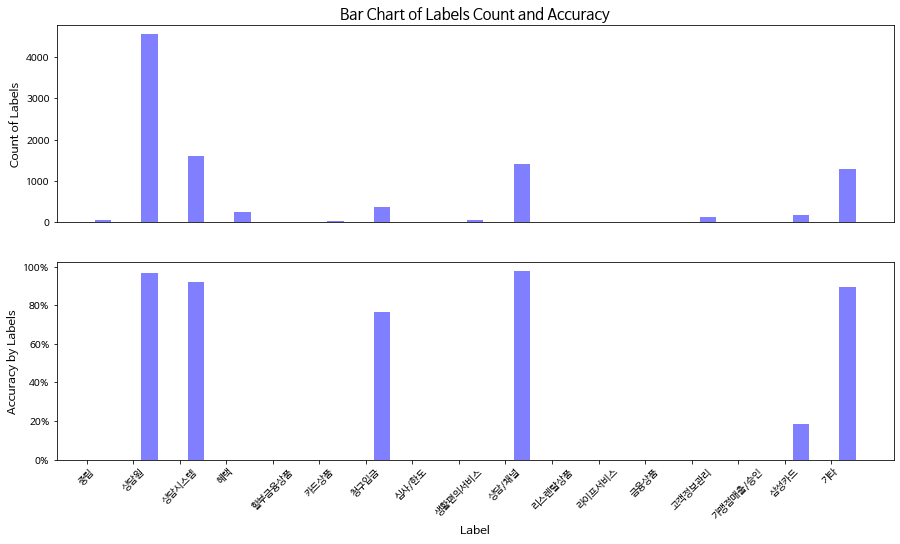

08/11/2021 10:20:35 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 10:20:35 - INFO - __main__ -     acc = 0.8701947079380928


                                              Review  Label Prediction
0  삼성카드 택배 배달 시 사전 전화 약속하고 카드 배달하세요 기본 아닙니까 집에서 작...   카드상품        상담원
1  홈페이지를 이용할 경우 오류가 잦아 매우 불편함 전화 문의는 대기 시간이 오래 걸려...  상담시스템      상담/채널
2  상담원과의 통화대기시간안내가 현실적으로 차이가 있을 때입니다 대기시간이 1시간 정도...  상담시스템      상담/채널
3                                 상담원 연결까지 너무 오랴 걸려요  상담시스템      상담/채널
4                4번과 5번은 크게 의미 없는데 다음단게로 넘어가기 위한 클릭임    상담원      상담/채널
{'acc': 0.8701947079380928}


KeyboardInterrupt: ignored

In [ ]:
results = {}
checkpoints = list(
            os.path.dirname(c) for c in
            sorted(glob.glob(args.output_dir + "/**/" + "pytorch_model.bin", recursive=True))
        )
if not args.eval_all_checkpoints:
    checkpoints = checkpoints[-1:]
else:
    logging.getLogger("transformers.configuration_utils").setLevel(logging.WARN)  # Reduce logging
    logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split("-")[-1]
    model = args.model.from_pretrained(checkpoint)
    model.to(args.device)
    result = evaluate(args, model, full_text, test_dataset, mode="test", global_step=global_step)
    result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
    results.update(result)

output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
with open(output_eval_file, "w") as f_w:
    for key in sorted(results.keys()):
        f_w.write("{} = {}\n".format(key, str(results[key])))

In [ ]:
# 수정금지: 타임스탬프
_model_build_end_time = printt("Model building: Start")
print(_model_build_end_time - _model_build_start_time)

NameError: ignored

#모델 분류

In [ ]:
# 수정금지: 타임스탬프
_test_start_time = printt("TEST: Start")

In [ ]:
#TODO: 해당 블럭에 테스트 수행을 위한 코드를 넣으세요. (시간측정 구간)
#분석 파일은 tsv 파일로 제공되며, 제공되는 학습데이터 파일과 동일한 레이아웃(단, 정답 분류 =공백)으로 제공됩니다.




In [ ]:
# 수정금지: 타임스탬프
_test_end_time = printt("Model building: Start")
print(_test_end_time - _test_start_time)

# 결과출력

In [ ]:
#TODO:해당 블럭에 테스트 결과를 파일로 저장하는 코드를 넣으세요. (시간측정 제외)
#저장 파일은tsv 파일로 제공되는 학습데이터 파일과 동일한 레이아웃(단, 정답 분류 = 테스트 결과 도출된 양식)으로 저장


